c:\users\drich\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
c:\users\drich\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in subtract


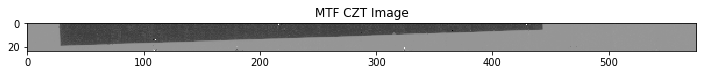

In [81]:
import os
import numpy as np
import matplotlib.pyplot as plt

import general_functions as gen

energy = 40  # Choices: 40, 120 kVp

directory = r'D:\OneDrive - University of Victoria\Research\LDA Data\ESF'
folder = f'ESF_{energy}kVp'
air_folder = f'airscan_60s_{energy}kVp'

# Open the image
raw_data = np.load(os.path.join(directory, folder, 'Data', 'data.npy'))
air = np.load(os.path.join(directory, air_folder, 'Data', 'data.npy'))

# Dead pixel mask
dpm = np.load(r'D:\OneDrive - University of Victoria\Research\LDA Data\dead_pixel_mask.npy')

# Correct the data
data = np.log(air) - np.log(raw_data)
data = gen.correct_dead_pixels(data, dead_pixel_mask=dpm)

data = data[:, :, 6]

# Show the image
fig = plt.figure(figsize=(12, 4))
plt.imshow(data, cmap="gray_r")
plt.title("MTF CZT Image")

plt.show()

# Get the pixel size
pixel = 0.33  # [mm]

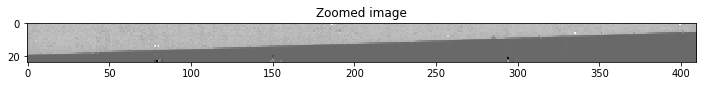

In [82]:
## Get just the MTF portion of the scan

scan = data[:, 30:440]

# Show the zoomed image
fig = plt.figure(figsize=(12, 4))
plt.imshow(scan, cmap="gray")
plt.title("Zoomed image")
plt.show()

In [83]:
## Get the pixel coordinates of the edge

# Get minimum value of the background
back = scan[14:,200:]

m = np.median(back)
# print(np.median(back))
# print(np.mean(back))
# print(np.std(back))

yrng = np.arange(24)
xrng = np.arange(410)

# Bottom edge pixel coord. array
edge = []

# Get the pixel coordinates of the bottom edge
for c in xrng:
    for r in yrng:
        if scan[r,c] < m+0.2:
            edge.append([r,c])
            break

edge = np.array(edge, subok=True)

In [84]:
## Calculate Nave for both edges using 1/tan(alpha)
## tan(alpha) = opp/adj
## Nave = adj/opp

# Calculate alpha for the edge relative to the horizontal axis
adj = np.ptp(edge[:,1])
opp = np.ptp(edge[:,0])

Nave = int(round(adj/opp))


In [85]:
## Create a number of oversampled edge functions for both edges

# Number of edge function for both edges
num = int(len(edge)/Nave)

# Array for the oversampled edge functions
EF = []

# Edge functions for the bottom edge
current = []
x = 0
for i in range(num):
    current = []
    x = edge[i*Nave]
    for j in range(x[0]-4, x[0]+4, 1):
        for k in range(Nave):
            current.append(scan[j, x[1]+k])
    EF.append(current)
EF = np.array(EF, subok=True)

In [86]:
## Average edge functions into one function
ESF = np.mean(EF, axis=0)

# Find the approximate edge within CE
mid = 0
for idx, val in enumerate(ESF):
    if val < m+0.3:
        mid = idx
        break

## Take the derivative of each by convolving with [-0.5 0 0.5] to get the LSF
der = [-0.5, 0, 0.5]
LSF = np.convolve(ESF, der)
LSF = np.absolute(LSF)
LSF = LSF[25:-25]    # Take just the middle around the edge

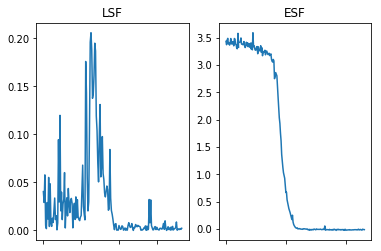

In [87]:
# Plot the line and edge functions
f, axarr = plt.subplots(1, 2)
axarr[0].plot(LSF)
axarr[0].set_title("LSF")
axarr[1].plot(ESF)
axarr[1].set_title("ESF")

plt.setp([a.get_xticklabels() for a in axarr], visible=False)
plt.show()

In [88]:
from scipy.fftpack import fft

# Find M
M = len(LSF)


# Get the frequencies to plot the MTF of the bottom edge over
freq = np.linspace(0,M/2,int(M/2))
freq = freq*Nave/(2*M*0.33)

# Calculate the MTF of the cathode side
mtf = fft(LSF)
mtf = np.absolute(mtf)
mtf = mtf[0:int(M/2)]
mtf = np.divide(mtf,np.max(mtf))

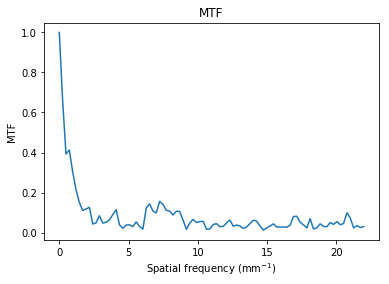

In [89]:
# Plot the two MTF's
fig = plt.figure()
plt.plot(freq,mtf)
plt.title("MTF")
plt.ylabel("MTF")
plt.xlabel("Spatial frequency (mm$^{-1}$)")
plt.show()
